### Import dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA

df = pd.read_csv('/Users/mac/Desktop/Chicago Housing Communities/Chicago Data.csv')

# rename columns
df.columns = ['area_number','area_name','pct_crowd','pct_poverty','pct_unemployed','pct_nohs','pct_18_64','income','hardship_index']
df.drop(['area_number','hardship_index'], axis = 1, inplace = True)
df.head()

,area_name,pct_crowd,pct_poverty,pct_unemployed,pct_nohs,pct_18_64,income
0,Rogers Park,7.7,23.6,8.7,18.2,27.5,23939
1,West Ridge,7.8,17.2,8.8,20.8,38.5,23040
2,Uptown,3.8,24.0,8.9,11.8,22.2,35787
3,Lincoln Square,3.4,10.9,8.2,13.4,25.5,37524
4,North Center,0.3,7.5,5.2,4.5,26.2,57123


Some noteskeeping:

pct_crowd: % of housing crowded \
pct_poverty: % of households below poverty \
pct_unemployed: % aged 16+ and unemployed \
pct_nohs: % aged 25+ without high school diploma \
pct_18_64: % aged under 18 or over 64 \
income: per capita income 

### Standardize each feature to have mean 0 and standard deviation 1. This is especially important since if income is not properly scaled the first PC will have a very heavy loading toward income. 

In [2]:
# Dropping area_name since the feature is not useful for building PCs
# and is only useful for identifying which communities are clustered together (if any). 
X = df.drop(['area_name'], axis = 1)
X = StandardScaler().fit_transform(X)
X.shape

(78, 6)

### Run PCA and extract the scores and vectors for the first 2 PCs 

In [3]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)

# merge PC scores to the main dataframe to identify corresponding area names later
pc_scores = pd.DataFrame(data = principalComponents, columns = ['pc' + str(i) for i in range(1,3)])
df = pd.concat([df, pc_scores], axis=1)
df.head()

,area_name,pct_crowd,pct_poverty,pct_unemployed,pct_nohs,pct_18_64,income,pc1,pc2
0,Rogers Park,7.7,23.6,8.7,18.2,27.5,23939,0.516883,1.086183
1,West Ridge,7.8,17.2,8.8,20.8,38.5,23040,0.001516,0.918711
2,Uptown,3.8,24.0,8.9,11.8,22.2,35787,1.748621,0.337486
3,Lincoln Square,3.4,10.9,8.2,13.4,25.5,37524,2.097717,0.566289
4,North Center,0.3,7.5,5.2,4.5,26.2,57123,3.569773,-0.101947


In [4]:
pca_coeff = pd.DataFrame(data = pca.components_, columns = df.columns[1:-2])
pca_coeff

,pct_crowd,pct_poverty,pct_unemployed,pct_nohs,pct_18_64,income
0,-0.339427,-0.396106,-0.412552,-0.416413,-0.396113,0.476849
1,0.626105,-0.279785,-0.459335,0.483172,-0.291970,-0.004741


### Identify the proportion of variance explained by PCs

The first two PCs collectively account for more than 80% of total variance. It is probably safe to disregard the rest of PCs for now.

In [5]:
pca.explained_variance_ratio_

array([0.61192684, 0.21855136])

### Build a biplot to measure the loadings of each feature for the first two PCs

Note that even though each PC is of unit length, I scale up the loadings of each feature by the same amount for visualization purposes.

In [6]:
# define the biplot function
def biplot(data, coeff, scale):
    fig, ax = plt.subplots(figsize=(40,30))
    plt.scatter(data['pc1'] , data['pc2'], s = 200)
    plt.xlabel("PC1", fontsize = 50)
    plt.ylabel("PC2", fontsize = 50)
    ax.tick_params(axis='both', which='major', labelsize=30)
    for i in range(6):
        plt.arrow(0, 0, coeff.iloc[0,i]*scale, coeff.iloc[1,i]*scale, color = 'r', width = 0.01)
        plt.text(coeff.iloc[0,i]*scale*1.1, coeff.iloc[1,i]*scale*1.1, coeff.columns[i], color = 'black', ha = 'center', va = 'center', size = 40)
    plt.grid()

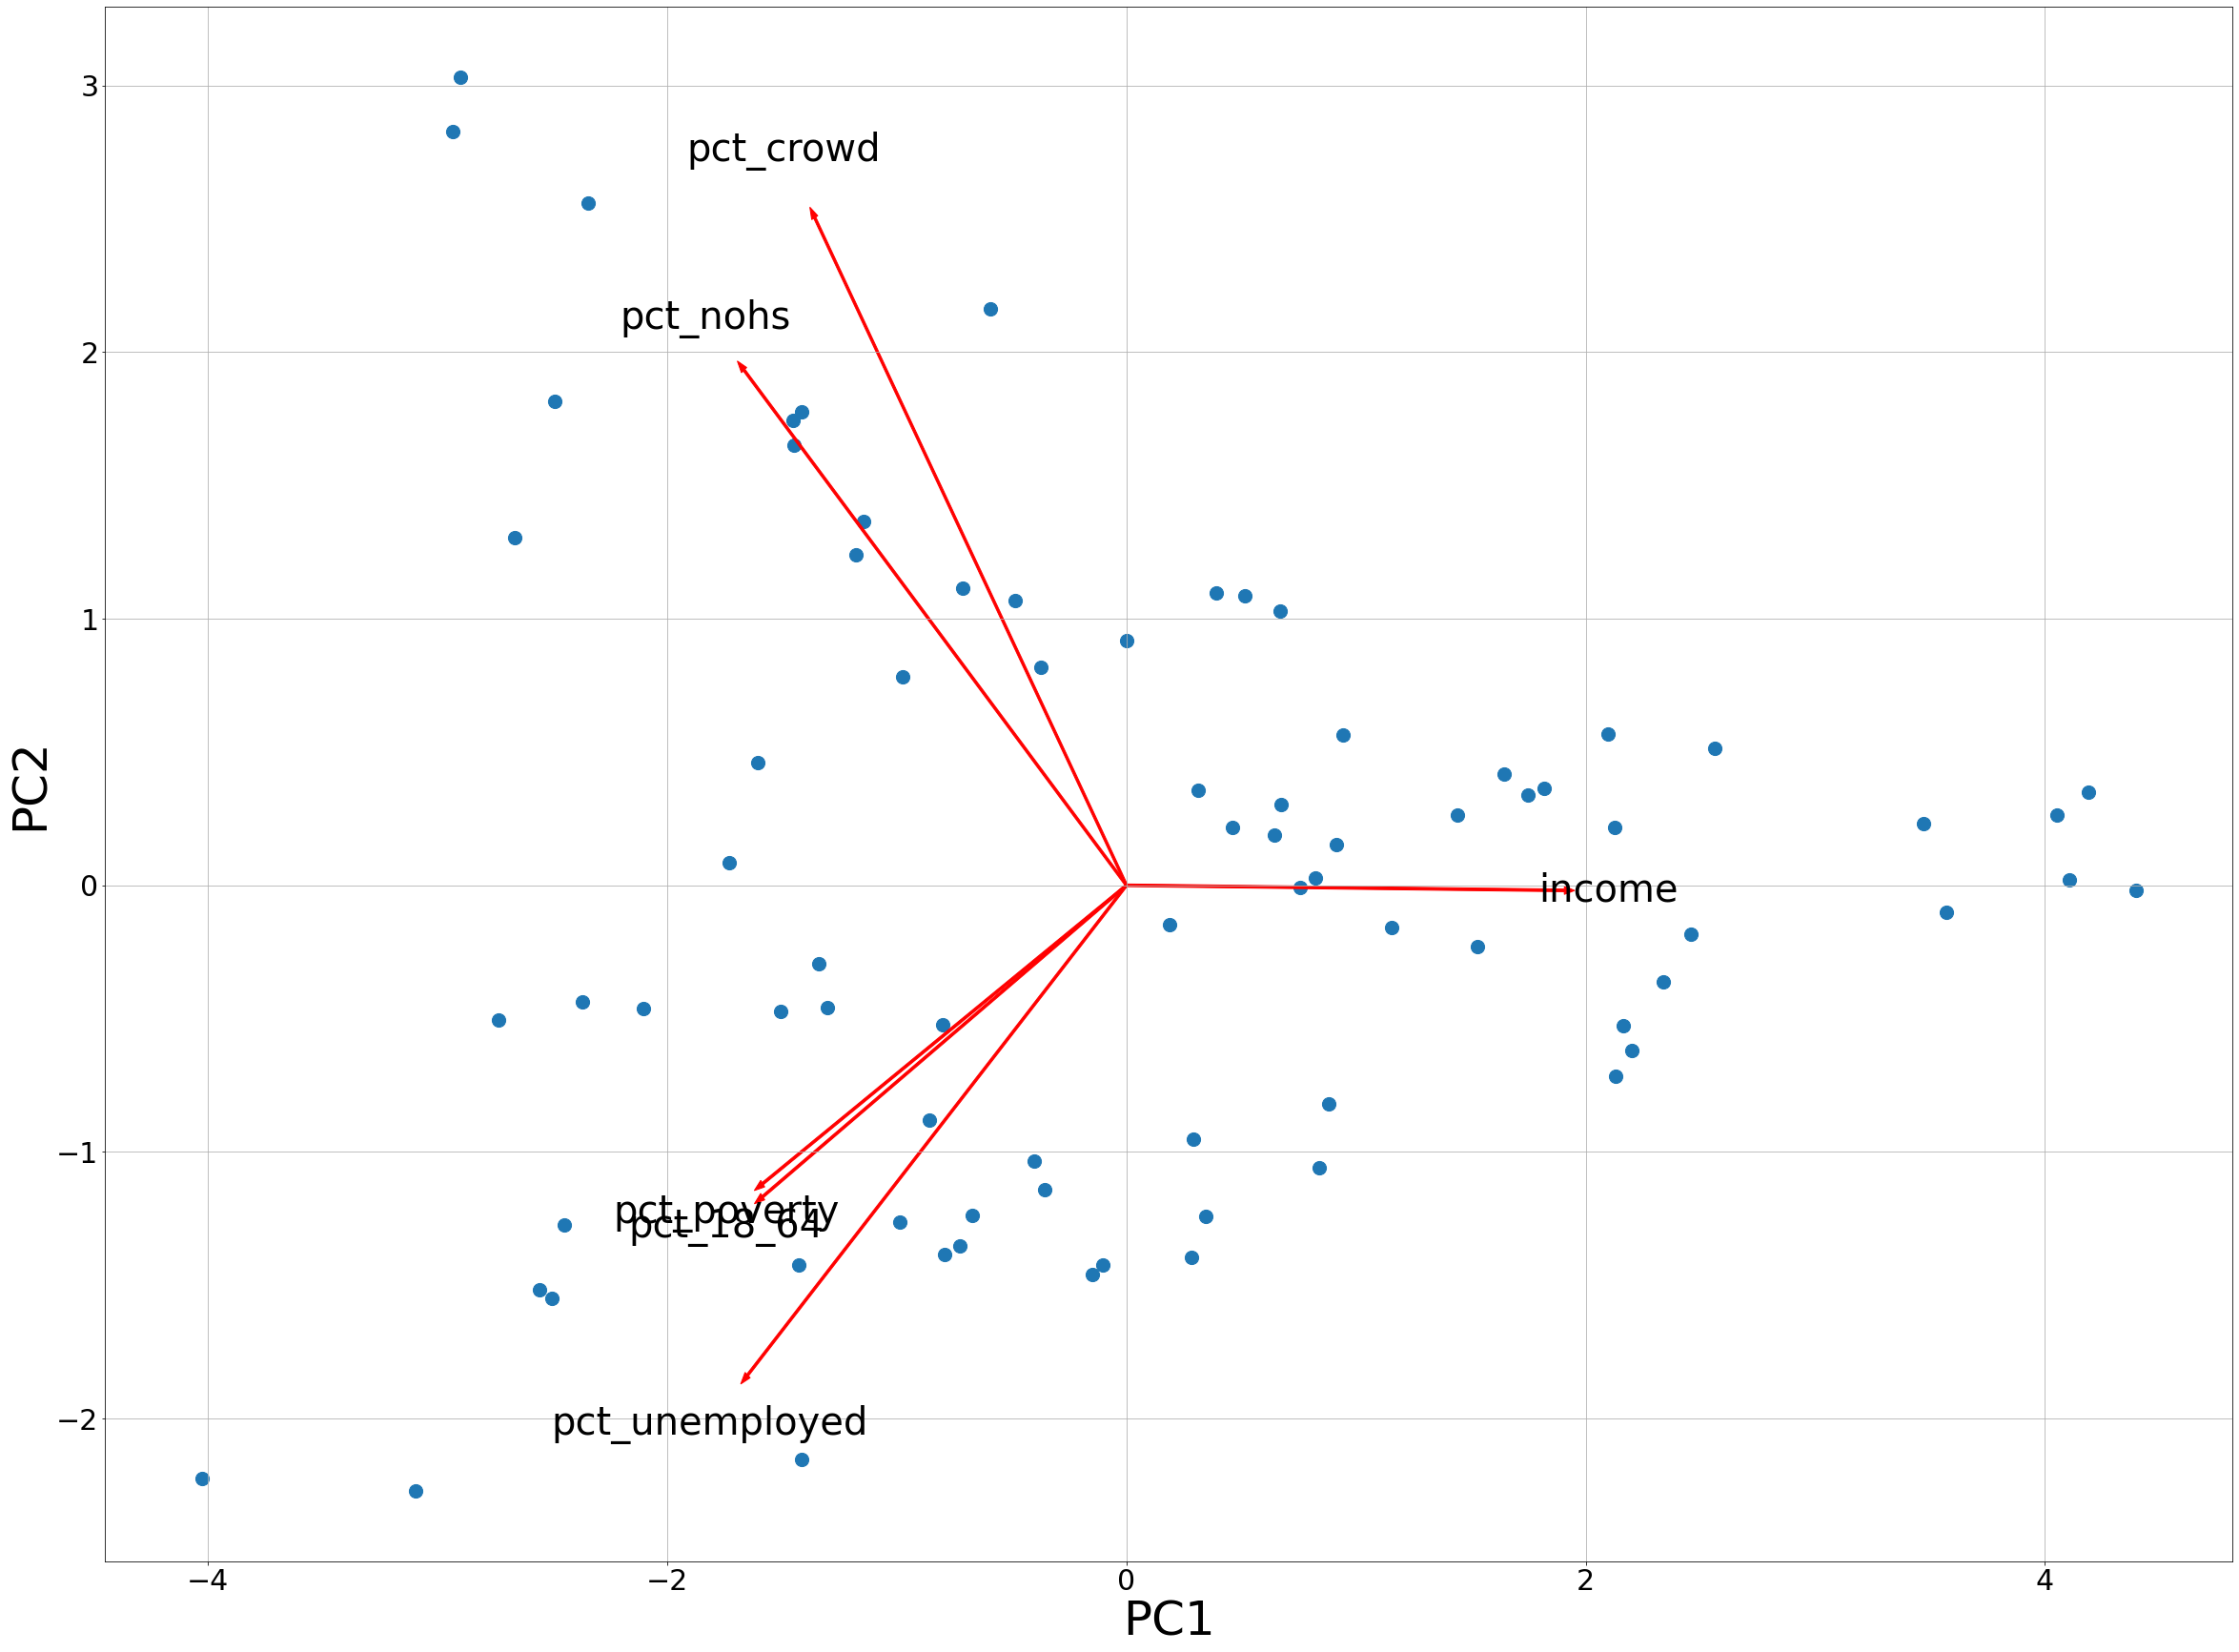

In [7]:
biplot(df, pca_coeff, 4)

### Some observations:

When projecting our data of 6 features to the first two PCs, we are not able to identify any obvious clusters of housing communities, except for maybe the six points to the very right. These six points have the highest PC1 scores: North Center, Lake View, Lincoln Park, Near North Side, Loop, and Near South Side. They are geographically within or just north of downtown Chicago and have relatively high average income.  

In [8]:
df[df['pc1'].isin(df['pc1'].nlargest(6))]

,area_name,pct_crowd,pct_poverty,pct_unemployed,pct_nohs,pct_18_64,income,pc1,pc2
4,North Center,0.3,7.5,5.2,4.5,26.2,57123,3.569773,-0.101947
5,Lake View,1.1,11.4,4.7,2.6,17.0,60058,4.051059,0.262354
6,Lincoln Park,0.8,12.3,5.1,3.6,21.5,71551,4.106615,0.020166
7,Near North Side,1.9,12.9,7.0,2.5,22.6,88669,4.397505,-0.017552
31,Loop,1.5,14.7,5.7,3.1,13.5,65526,4.189925,0.348666
32,Near South Side,1.3,13.8,4.9,7.4,21.8,59077,3.472854,0.230872


Based on the first PC, we find that all of the % related loadings are of the negative sign and of close magnitude, whereas income have a positive sign and of a much larger magnitude.

If we look at the second PC, we see that income has virtually no loading here. In addition, pct_crowded and pct_nohs are similar in sign and magnitude whereas pct_poverty, pct_18_64, and pct_unemployed constitute another group. This might indicates that some % features are more closely related than others. We can verify using a correlation matrix below. 

In [9]:
df[['pct_crowd','pct_poverty','pct_unemployed','pct_nohs','pct_18_64','income']].corr()

,pct_crowd,pct_poverty,pct_unemployed,pct_nohs,pct_18_64,income
pct_crowd,1.000000,0.319403,0.165299,0.875959,0.224692,-0.541730
pct_poverty,0.319403,1.000000,0.800084,0.424294,0.435894,-0.567025
pct_unemployed,0.165299,0.800084,1.000000,0.355518,0.676532,-0.656619
pct_nohs,0.875959,0.424294,0.355518,1.000000,0.408878,-0.709770
pct_18_64,0.224692,0.435894,0.676532,0.408878,1.000000,-0.754844
income,-0.541730,-0.567025,-0.656619,-0.709770,-0.754844,1.000000


The points projected to the first two PCs show a triangular shape, indicating that there may exist some nonlinear components we are not capturing. In light of this finding, I move on to kernel PCAs.

### There are a few kernel types to select from.  I only demonstrate using the polynomial kernel here. The number of degree is selected after some experimentations to see which one yields the most interesting result.

In [10]:
kpca_poly = KernelPCA(n_components = 2, kernel= "poly", degree = 8)
principalComponents = kpca_poly.fit_transform(X)
principalComponents

kpca_poly_scores = pd.DataFrame(data = principalComponents, columns = ['kpc1', 'kpc2'])

df = pd.concat([df, kpca_poly_scores], axis=1)
df.head()

,area_name,pct_crowd,pct_poverty,pct_unemployed,pct_nohs,pct_18_64,income,pc1,pc2,kpc1,kpc2
0,Rogers Park,7.7,23.6,8.7,18.2,27.5,23939,0.516883,1.086183,-21.856710,-10.611518
1,West Ridge,7.8,17.2,8.8,20.8,38.5,23040,0.001516,0.918711,-21.901163,-10.607877
2,Uptown,3.8,24.0,8.9,11.8,22.2,35787,1.748621,0.337486,-19.177100,-10.705835
3,Lincoln Square,3.4,10.9,8.2,13.4,25.5,37524,2.097717,0.566289,-18.842324,-10.690383
4,North Center,0.3,7.5,5.2,4.5,26.2,57123,3.569773,-0.101947,42.663419,-9.678247


As seen below, most points are concentrated on a small area. We are interested in seeing which are the 8 points far away from the main cluster. There are 6 points corresponding to the top 6 KPC1 scores and 2 points corresponding to the top 2 KPC2 scores. 

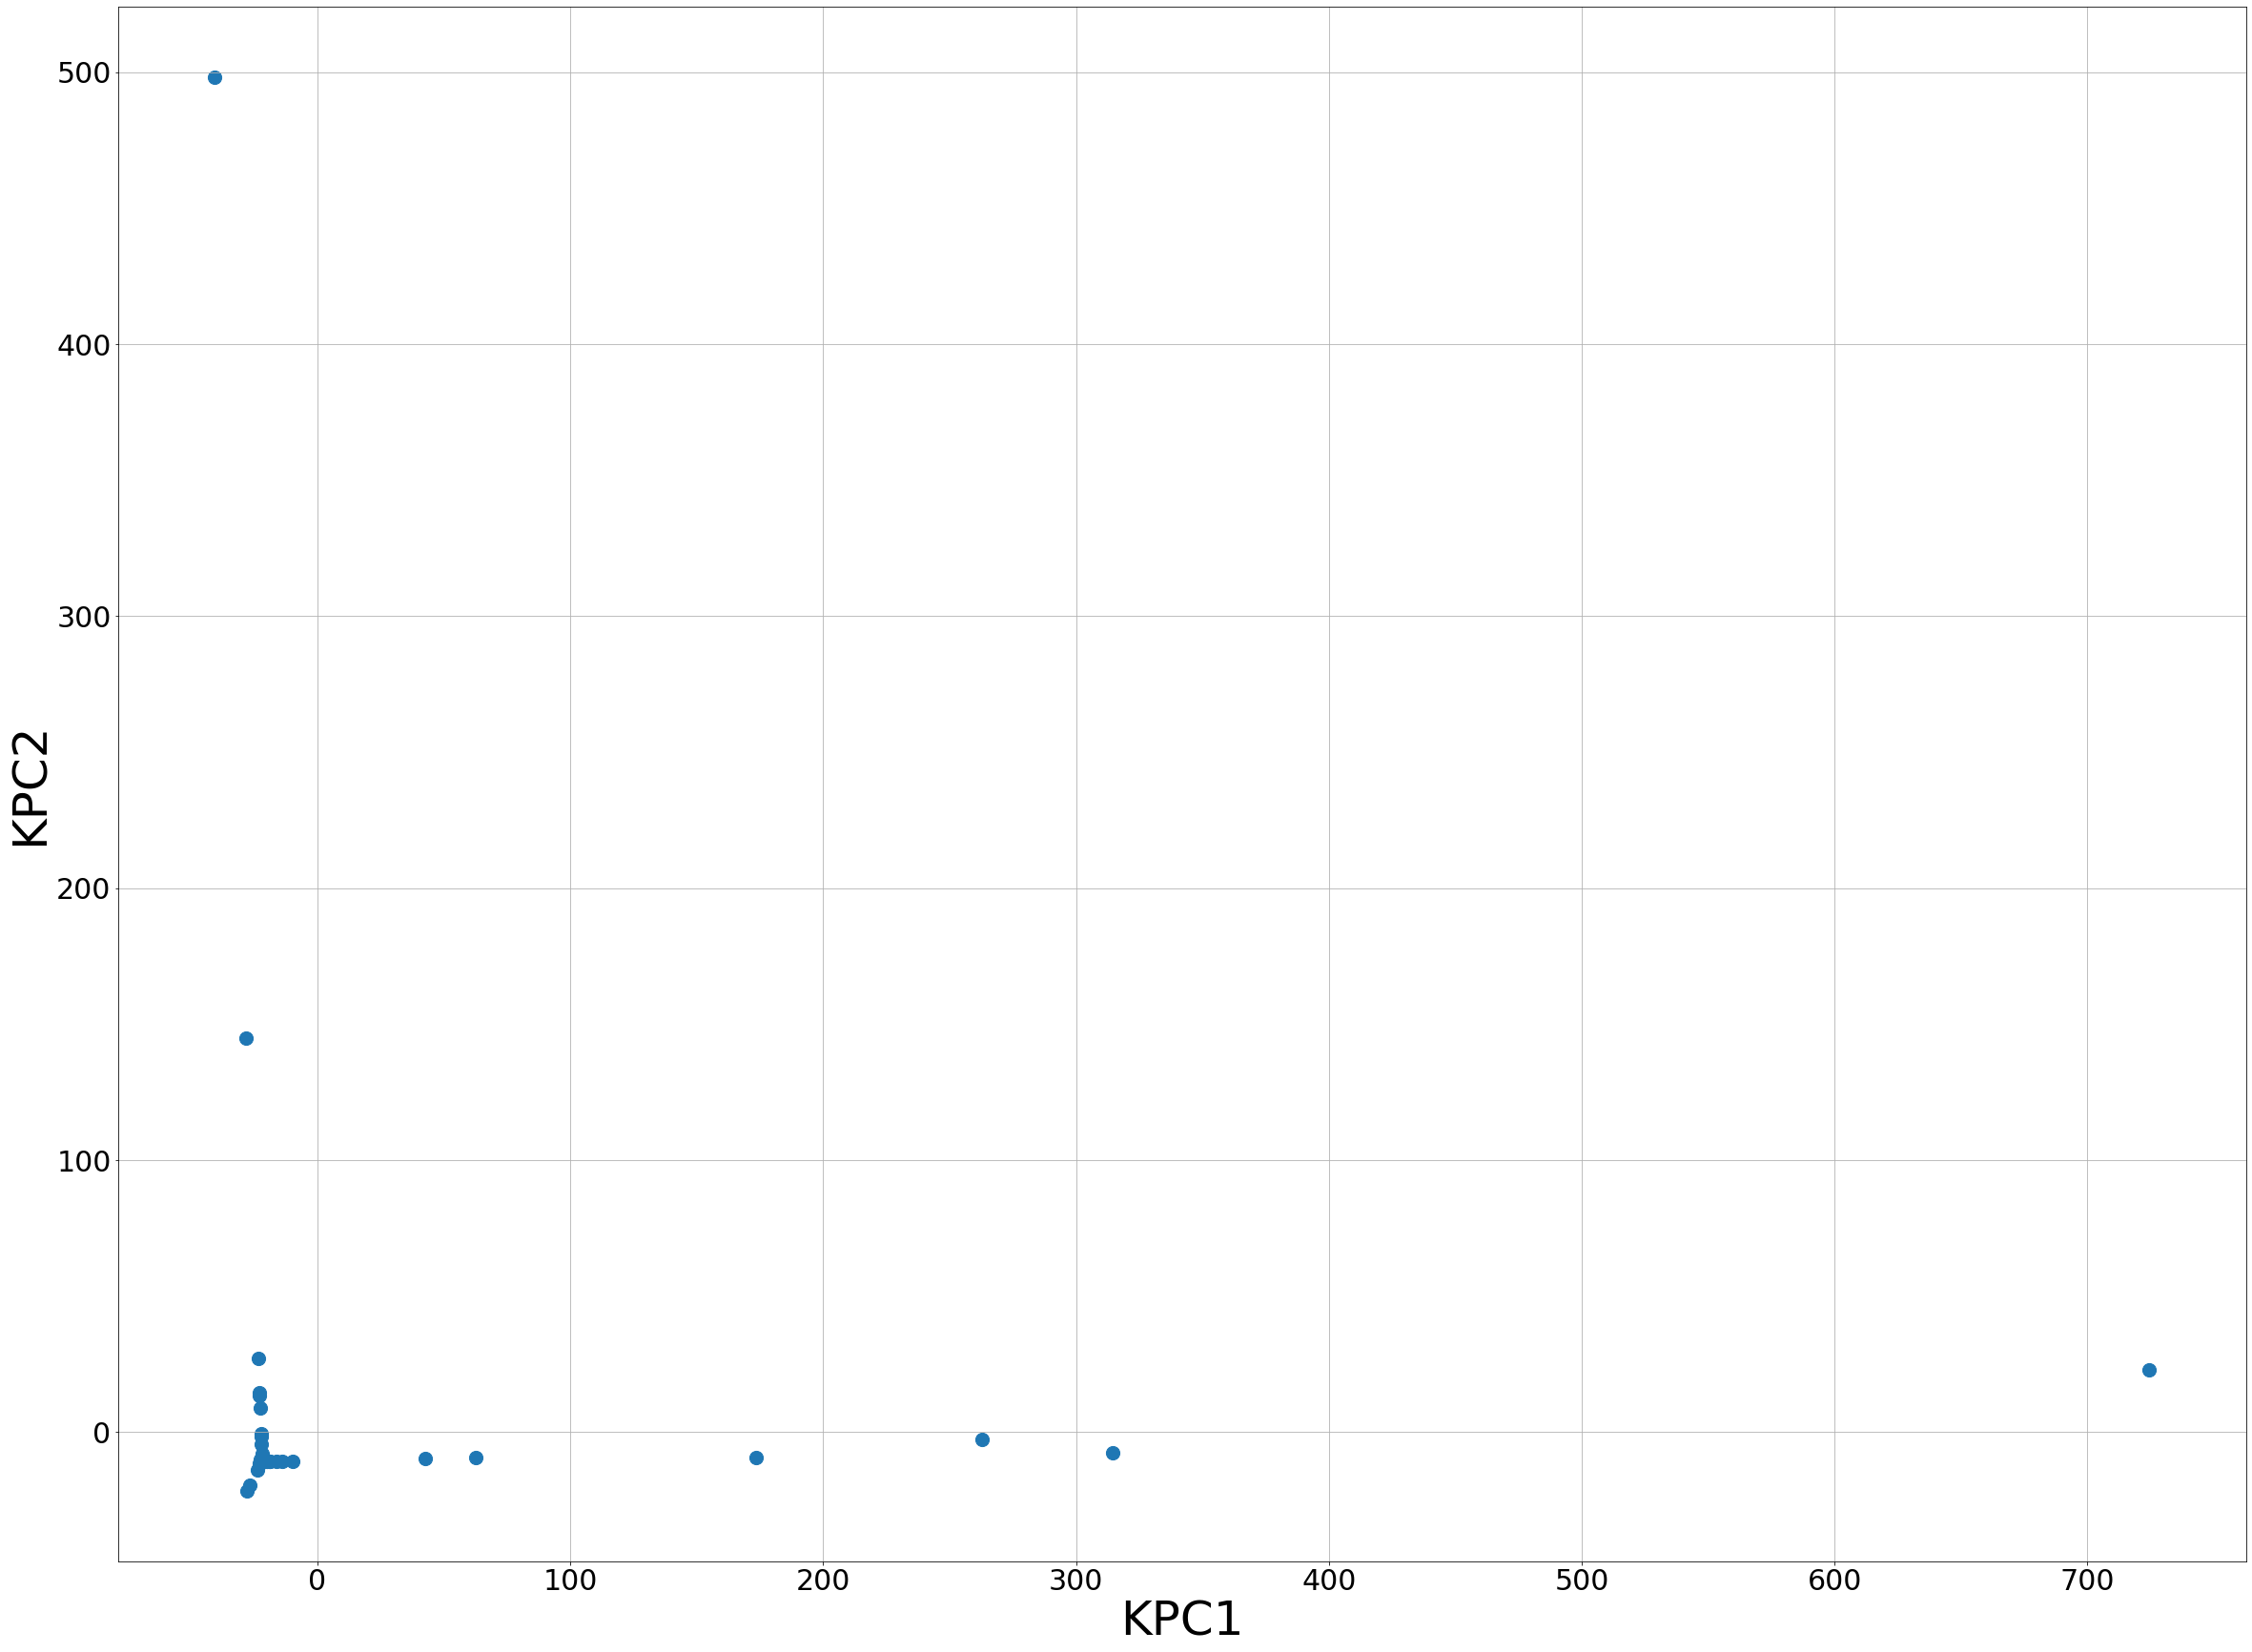

In [11]:
fig, ax = plt.subplots(figsize=(40,30))
plt.scatter(df['kpc1'] ,df['kpc2'], s = 200)
plt.xlabel("KPC1", fontsize = 50)
plt.ylabel("KPC2", fontsize = 50)
ax.tick_params(axis='both', which='major', labelsize=30)
plt.grid()

Not surprisingly, the six points with the highest KPC1 scores are exactly the same as the ones found by PCA.

In [12]:
df[df['kpc1'].isin(df['kpc1'].nlargest(6))]

,area_name,pct_crowd,pct_poverty,pct_unemployed,pct_nohs,pct_18_64,income,pc1,pc2,kpc1,kpc2
4,North Center,0.3,7.5,5.2,4.5,26.2,57123,3.569773,-0.101947,42.663419,-9.678247
5,Lake View,1.1,11.4,4.7,2.6,17.0,60058,4.051059,0.262354,173.663733,-9.444697
6,Lincoln Park,0.8,12.3,5.1,3.6,21.5,71551,4.106615,0.020166,262.670688,-2.798483
7,Near North Side,1.9,12.9,7.0,2.5,22.6,88669,4.397505,-0.017552,724.444833,22.926125
31,Loop,1.5,14.7,5.7,3.1,13.5,65526,4.189925,0.348666,314.470478,-7.514147
32,Near South Side,1.3,13.8,4.9,7.4,21.8,59077,3.472854,0.230872,62.513575,-9.519737


The two points with the highest KPC2 scores actually correspond to the two points with the smallest PC2 scores from PCA. 

In [13]:
df[df['kpc2'].isin(df['kpc2'].nlargest(2))]

,area_name,pct_crowd,pct_poverty,pct_unemployed,pct_nohs,pct_18_64,income,pc1,pc2,kpc1,kpc2
36,Fuller Park,3.2,51.2,33.9,26.6,44.9,10432,-3.097181,-2.270564,-28.081247,144.984767
53,Riverdale,5.8,56.5,34.6,27.5,51.5,8201,-4.026899,-2.224491,-40.688673,498.130675


In [14]:
df[df['pc2'].isin(df['pc2'].nsmallest(2))]

,area_name,pct_crowd,pct_poverty,pct_unemployed,pct_nohs,pct_18_64,income,pc1,pc2,kpc1,kpc2
36,Fuller Park,3.2,51.2,33.9,26.6,44.9,10432,-3.097181,-2.270564,-28.081247,144.984767
53,Riverdale,5.8,56.5,34.6,27.5,51.5,8201,-4.026899,-2.224491,-40.688673,498.130675


### Conclusion
Using just PCA, I was able to only identify the six communities with overall better socioeconomic characteristics. However, upon using the polynomial kernel, I was able to identify one additional "cluster" consisting of Fuller Park and Riverdale. Since PCA/KPCA is an unsupervised learning technique, further exploration into how these groups of communities singled out might be related to each other would be helpful.